## Equation 
The equation we are testing is

$$
\begin{cases}
u'(x) + u(x) = x, \qquad\text{for}\; 0<x<1,\\
u(0) = 1.
\end{cases}
$$ 

The exact solution is
$$ u^*(x) = x-1+2e^{-x}.$$



In [1]:
# Import libraries
import numpy as np
import math
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [2]:
def u_star_func(x):
    result = x-1+2*np.exp(-x)
    return result

import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss, title='Loss'):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.savefig(title +".png")  # should before show method

    # show
    plt.show()

# plt.plot(test_error_vec)
# plt.show()


def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true solution')
    plt.plot(lst_iter, lst_acc, '-r', label='PINNs')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.savefig(title+".png")  # should before show method
    plt.show()

## Backpropagation - 16 neurons/layer


In [3]:
input_size = 1
output_size = 1
k = 16
model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),
                      
                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Tanh()
)


In [ ]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)

In [ ]:
x_init_np

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [ ]:
x_init_np = x_init_np[1:-1]
x_init = torch.tensor(x_init_np, requires_grad= True)
# print(x_init)
print(x_init.shape)

torch.Size([99])


The running loss at 0 iteration is: 0.5926810503005981
The running loss at 1 iteration is: 0.3285556733608246
The running loss at 2 iteration is: 0.17291365563869476
The running loss at 3 iteration is: 0.07443434000015259
The running loss at 4 iteration is: 0.020480774343013763
The running loss at 5 iteration is: 0.015170485712587833
The running loss at 6 iteration is: 0.02991272322833538
The running loss at 7 iteration is: 0.0261674914509058
The running loss at 8 iteration is: 0.009324283339083195
The running loss at 9 iteration is: 0.003187241731211543
The running loss at 10 iteration is: 0.014298014342784882
The running loss at 11 iteration is: 0.021091323345899582
The running loss at 12 iteration is: 0.013211849145591259
The running loss at 13 iteration is: 0.003105700481683016
The running loss at 14 iteration is: 0.004260072484612465
The running loss at 15 iteration is: 0.012134197168052197
The running loss at 16 iteration is: 0.012848306447267532
The running loss at 17 iteration 

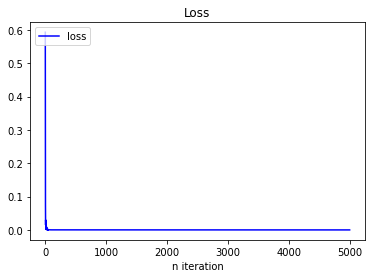

The running loss at 5000 iteration is: 5.1465482101775706e-05


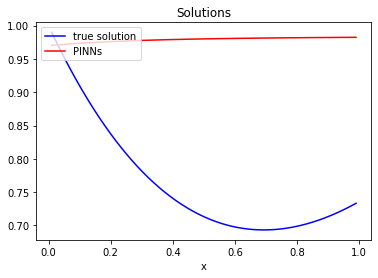

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
time0 = time()
num_e = 5000
iter = []
test_error_vec = []
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1)
for e in range(num_e):
    running_loss = 0
    # call zero_Grad
    optimizer.zero_grad() 
    # Compute u_hat, d2u_hat
    u_hat = torch.tensor(np.array([]))
    du_dx = torch.tensor(np.array([]))
    for xi in x_init_np:
        x_tensor = torch.tensor([xi], requires_grad=True)
        temp = model(x_tensor.float())
        u_hat = torch.hstack([u_hat, temp])
        deri = autograd.grad(model(x_tensor.float()), x_tensor, create_graph=True)[0]
        du_dx = torch.hstack([du_dx, deri])
    loss = torch.mean((du_dx + u_hat - x_tensor)**2) + (model(torch.tensor([0.])-1))**2
    loss.backward()
    optimizer.step() 
    scheduler2.step()

    running_loss += loss.clone().item()    
    
    print(f"The running loss at {e} iteration is: {running_loss}")
    test_error_vec.append(running_loss)
    iter.append(e)

draw_result(iter, test_error_vec)
print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
y_true = u_star_func(x_init_np)
draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')

In [ ]:
u_hat

tensor([0.9703, 0.9707, 0.9711, 0.9715, 0.9719, 0.9722, 0.9726, 0.9729, 0.9732,
        0.9735, 0.9738, 0.9741, 0.9744, 0.9746, 0.9749, 0.9751, 0.9754, 0.9756,
        0.9758, 0.9760, 0.9762, 0.9764, 0.9766, 0.9768, 0.9770, 0.9772, 0.9773,
        0.9775, 0.9777, 0.9778, 0.9780, 0.9781, 0.9782, 0.9784, 0.9785, 0.9786,
        0.9788, 0.9789, 0.9790, 0.9791, 0.9792, 0.9793, 0.9794, 0.9795, 0.9796,
        0.9797, 0.9798, 0.9799, 0.9800, 0.9801, 0.9802, 0.9803, 0.9803, 0.9804,
        0.9805, 0.9806, 0.9806, 0.9807, 0.9808, 0.9808, 0.9809, 0.9810, 0.9810,
        0.9811, 0.9811, 0.9812, 0.9813, 0.9813, 0.9814, 0.9814, 0.9815, 0.9815,
        0.9816, 0.9816, 0.9817, 0.9817, 0.9817, 0.9818, 0.9818, 0.9819, 0.9819,
        0.9819, 0.9820, 0.9820, 0.9821, 0.9821, 0.9821, 0.9822, 0.9822, 0.9822,
        0.9822, 0.9823, 0.9823, 0.9823, 0.9824, 0.9824, 0.9824, 0.9824, 0.9825],
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [ ]:
model(torch.tensor([0.])), (model(torch.tensor([0.])-1))**2

(tensor([0.9699], grad_fn=<TanhBackward0>),
 tensor([4.6496e-09], grad_fn=<PowBackward0>))

In [ ]:
torch.mean((du_dx + u_hat - x_tensor)**2) + (model(torch.tensor([0.])-1))**2

tensor([5.1465e-05], grad_fn=<AddBackward0>)

In [ ]:
du_dx

tensor([0.0421, 0.0404, 0.0389, 0.0374, 0.0360, 0.0346, 0.0334, 0.0321, 0.0310,
        0.0298, 0.0288, 0.0278, 0.0268, 0.0258, 0.0249, 0.0241, 0.0233, 0.0225,
        0.0217, 0.0210, 0.0203, 0.0196, 0.0190, 0.0184, 0.0178, 0.0172, 0.0167,
        0.0162, 0.0157, 0.0152, 0.0147, 0.0143, 0.0138, 0.0134, 0.0130, 0.0126,
        0.0123, 0.0119, 0.0116, 0.0112, 0.0109, 0.0106, 0.0103, 0.0100, 0.0097,
        0.0095, 0.0092, 0.0090, 0.0087, 0.0085, 0.0083, 0.0080, 0.0078, 0.0076,
        0.0074, 0.0072, 0.0070, 0.0069, 0.0067, 0.0065, 0.0063, 0.0062, 0.0060,
        0.0059, 0.0057, 0.0056, 0.0054, 0.0053, 0.0052, 0.0051, 0.0049, 0.0048,
        0.0047, 0.0046, 0.0045, 0.0044, 0.0043, 0.0042, 0.0041, 0.0040, 0.0039,
        0.0038, 0.0037, 0.0036, 0.0035, 0.0035, 0.0034, 0.0033, 0.0032, 0.0031,
        0.0031, 0.0030, 0.0029, 0.0029, 0.0028, 0.0027, 0.0027, 0.0026, 0.0026],
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [ ]:
torch.mean(du_dx), torch.var(du_dx)

(tensor(0.0125, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0001, dtype=torch.float64, grad_fn=<VarBackward0>))

## Backpropagation - 200 neurons/layer


In [4]:
input_size = 1
output_size = 1
k = 200
model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),
                      
                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=200, bias=True)
  (5): Tanh()
  (6): Linear(in_features=200, out_features=1, bias=True)
  (7): Tanh()
)


In [5]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init_np = x_init_np[1:-1]
x_init = torch.tensor(x_init_np, requires_grad= True)
# print(x_init)
print(x_init.shape)

torch.Size([99])


The running loss at 0 iteration is: 1.2013237476348877


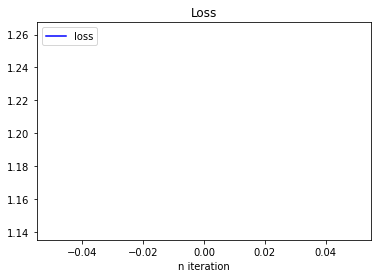

The running loss at 10000 iteration is: 1.2013237476348877


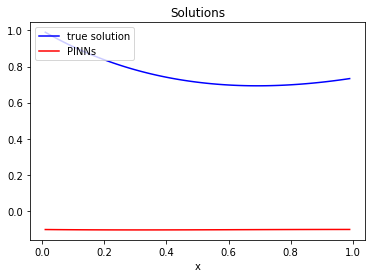

The running loss at 1 iteration is: 0.8901363611221313
The running loss at 2 iteration is: 0.999230682849884
The running loss at 3 iteration is: 1.0000509023666382
The running loss at 4 iteration is: 1.0000349283218384
The running loss at 5 iteration is: 1.0000689029693604
The running loss at 6 iteration is: 1.0003114938735962
The running loss at 7 iteration is: 1.0008509159088135
The running loss at 8 iteration is: 1.0009844303131104
The running loss at 9 iteration is: 1.0004651546478271
The running loss at 10 iteration is: 1.0001310110092163
The running loss at 11 iteration is: 1.0000252723693848
The running loss at 12 iteration is: 0.9999991059303284
The running loss at 13 iteration is: 0.9999958276748657
The running loss at 14 iteration is: 0.9999987483024597
The running loss at 15 iteration is: 1.0000025033950806
The running loss at 16 iteration is: 1.0000057220458984
The running loss at 17 iteration is: 1.0000081062316895
The running loss at 18 iteration is: 1.000009536743164
The

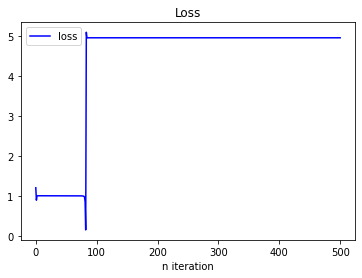

The running loss at 10000 iteration is: 4.960100173950195


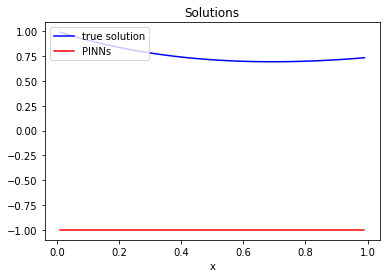

The running loss at 501 iteration is: 4.960100173950195
The running loss at 502 iteration is: 4.960100173950195
The running loss at 503 iteration is: 4.960100173950195
The running loss at 504 iteration is: 4.960100173950195
The running loss at 505 iteration is: 4.960100173950195
The running loss at 506 iteration is: 4.960100173950195
The running loss at 507 iteration is: 4.960100173950195
The running loss at 508 iteration is: 4.960100173950195
The running loss at 509 iteration is: 4.960100173950195
The running loss at 510 iteration is: 4.960100173950195
The running loss at 511 iteration is: 4.960100173950195
The running loss at 512 iteration is: 4.960100173950195
The running loss at 513 iteration is: 4.960100173950195
The running loss at 514 iteration is: 4.960100173950195
The running loss at 515 iteration is: 4.960100173950195
The running loss at 516 iteration is: 4.960100173950195
The running loss at 517 iteration is: 4.960100173950195
The running loss at 518 iteration is: 4.96010017

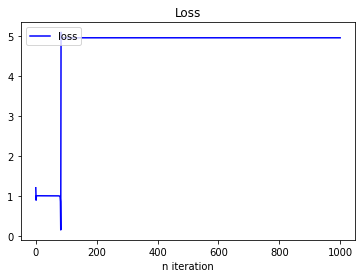

The running loss at 10000 iteration is: 4.960100173950195


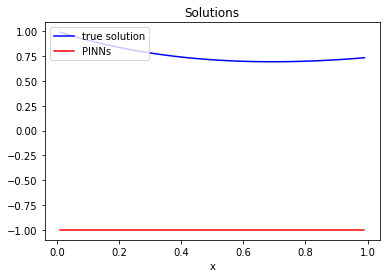

The running loss at 1001 iteration is: 4.960100173950195
The running loss at 1002 iteration is: 4.960100173950195
The running loss at 1003 iteration is: 4.960100173950195
The running loss at 1004 iteration is: 4.960100173950195
The running loss at 1005 iteration is: 4.960100173950195
The running loss at 1006 iteration is: 4.960100173950195
The running loss at 1007 iteration is: 4.960100173950195
The running loss at 1008 iteration is: 4.960100173950195
The running loss at 1009 iteration is: 4.960100173950195
The running loss at 1010 iteration is: 4.960100173950195
The running loss at 1011 iteration is: 4.960100173950195
The running loss at 1012 iteration is: 4.960100173950195
The running loss at 1013 iteration is: 4.960100173950195
The running loss at 1014 iteration is: 4.960100173950195
The running loss at 1015 iteration is: 4.960100173950195
The running loss at 1016 iteration is: 4.960100173950195
The running loss at 1017 iteration is: 4.960100173950195
The running loss at 1018 iterat

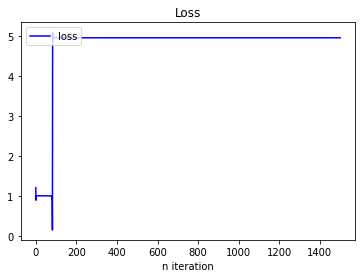

The running loss at 10000 iteration is: 4.960100173950195


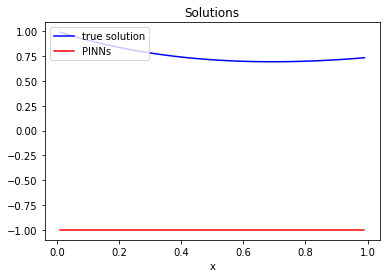

The running loss at 1501 iteration is: 4.960100173950195
The running loss at 1502 iteration is: 4.960100173950195
The running loss at 1503 iteration is: 4.960100173950195
The running loss at 1504 iteration is: 4.960100173950195
The running loss at 1505 iteration is: 4.960100173950195
The running loss at 1506 iteration is: 4.960100173950195
The running loss at 1507 iteration is: 4.960100173950195
The running loss at 1508 iteration is: 4.960100173950195
The running loss at 1509 iteration is: 4.960100173950195
The running loss at 1510 iteration is: 4.960100173950195
The running loss at 1511 iteration is: 4.960100173950195
The running loss at 1512 iteration is: 4.960100173950195
The running loss at 1513 iteration is: 4.960100173950195
The running loss at 1514 iteration is: 4.960100173950195
The running loss at 1515 iteration is: 4.960100173950195
The running loss at 1516 iteration is: 4.960100173950195
The running loss at 1517 iteration is: 4.960100173950195
The running loss at 1518 iterat

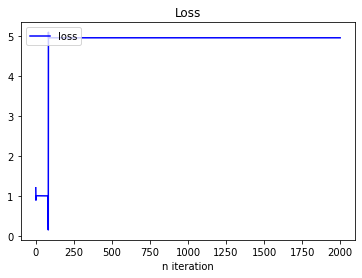

The running loss at 10000 iteration is: 4.960100173950195


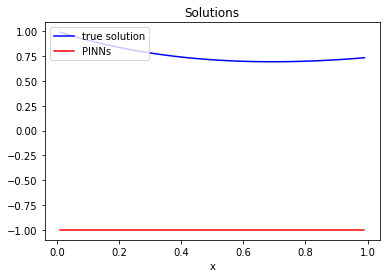

The running loss at 2001 iteration is: 4.960100173950195
The running loss at 2002 iteration is: 4.960100173950195
The running loss at 2003 iteration is: 4.960100173950195
The running loss at 2004 iteration is: 4.960100173950195
The running loss at 2005 iteration is: 4.960100173950195
The running loss at 2006 iteration is: 4.960100173950195
The running loss at 2007 iteration is: 4.960100173950195
The running loss at 2008 iteration is: 4.960100173950195
The running loss at 2009 iteration is: 4.960100173950195
The running loss at 2010 iteration is: 4.960100173950195
The running loss at 2011 iteration is: 4.960100173950195
The running loss at 2012 iteration is: 4.960100173950195
The running loss at 2013 iteration is: 4.960100173950195
The running loss at 2014 iteration is: 4.960100173950195
The running loss at 2015 iteration is: 4.960100173950195
The running loss at 2016 iteration is: 4.960100173950195
The running loss at 2017 iteration is: 4.960100173950195
The running loss at 2018 iterat

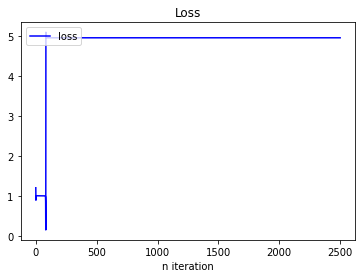

The running loss at 10000 iteration is: 4.960100173950195


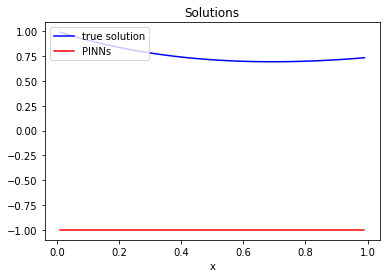

The running loss at 2501 iteration is: 4.960100173950195
The running loss at 2502 iteration is: 4.960100173950195
The running loss at 2503 iteration is: 4.960100173950195
The running loss at 2504 iteration is: 4.960100173950195
The running loss at 2505 iteration is: 4.960100173950195
The running loss at 2506 iteration is: 4.960100173950195
The running loss at 2507 iteration is: 4.960100173950195
The running loss at 2508 iteration is: 4.960100173950195
The running loss at 2509 iteration is: 4.960100173950195
The running loss at 2510 iteration is: 4.960100173950195
The running loss at 2511 iteration is: 4.960100173950195
The running loss at 2512 iteration is: 4.960100173950195
The running loss at 2513 iteration is: 4.960100173950195
The running loss at 2514 iteration is: 4.960100173950195
The running loss at 2515 iteration is: 4.960100173950195
The running loss at 2516 iteration is: 4.960100173950195
The running loss at 2517 iteration is: 4.960100173950195
The running loss at 2518 iterat

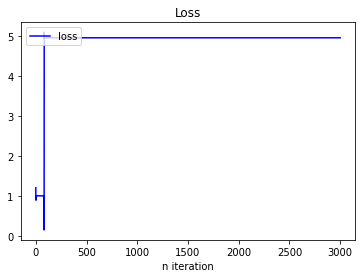

The running loss at 10000 iteration is: 4.960100173950195


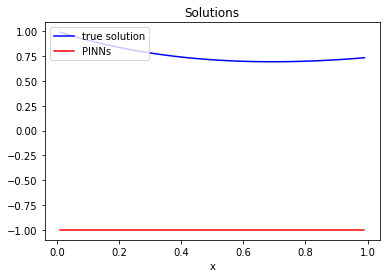

The running loss at 3001 iteration is: 4.960100173950195
The running loss at 3002 iteration is: 4.960100173950195
The running loss at 3003 iteration is: 4.960100173950195
The running loss at 3004 iteration is: 4.960100173950195
The running loss at 3005 iteration is: 4.960100173950195
The running loss at 3006 iteration is: 4.960100173950195
The running loss at 3007 iteration is: 4.960100173950195
The running loss at 3008 iteration is: 4.960100173950195
The running loss at 3009 iteration is: 4.960100173950195
The running loss at 3010 iteration is: 4.960100173950195
The running loss at 3011 iteration is: 4.960100173950195
The running loss at 3012 iteration is: 4.960100173950195
The running loss at 3013 iteration is: 4.960100173950195
The running loss at 3014 iteration is: 4.960100173950195
The running loss at 3015 iteration is: 4.960100173950195
The running loss at 3016 iteration is: 4.960100173950195
The running loss at 3017 iteration is: 4.960100173950195
The running loss at 3018 iterat

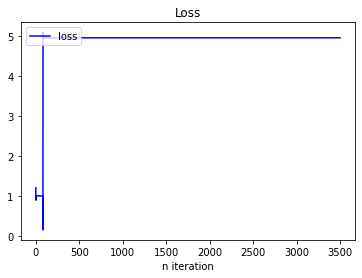

The running loss at 10000 iteration is: 4.960100173950195


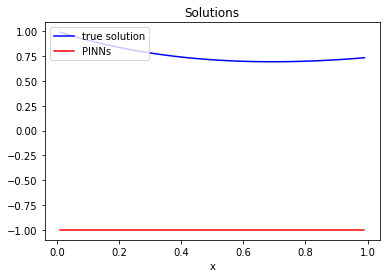

The running loss at 3501 iteration is: 4.960100173950195
The running loss at 3502 iteration is: 4.960100173950195
The running loss at 3503 iteration is: 4.960100173950195
The running loss at 3504 iteration is: 4.960100173950195
The running loss at 3505 iteration is: 4.960100173950195
The running loss at 3506 iteration is: 4.960100173950195
The running loss at 3507 iteration is: 4.960100173950195
The running loss at 3508 iteration is: 4.960100173950195
The running loss at 3509 iteration is: 4.960100173950195
The running loss at 3510 iteration is: 4.960100173950195
The running loss at 3511 iteration is: 4.960100173950195
The running loss at 3512 iteration is: 4.960100173950195
The running loss at 3513 iteration is: 4.960100173950195
The running loss at 3514 iteration is: 4.960100173950195
The running loss at 3515 iteration is: 4.960100173950195
The running loss at 3516 iteration is: 4.960100173950195
The running loss at 3517 iteration is: 4.960100173950195
The running loss at 3518 iterat

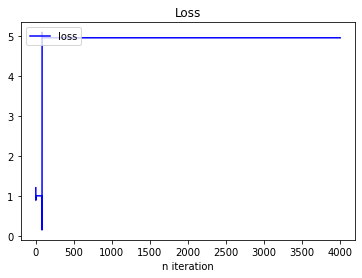

The running loss at 10000 iteration is: 4.960100173950195


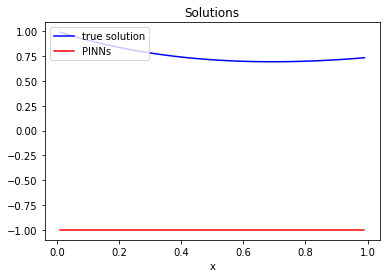

The running loss at 4001 iteration is: 4.960100173950195
The running loss at 4002 iteration is: 4.960100173950195
The running loss at 4003 iteration is: 4.960100173950195
The running loss at 4004 iteration is: 4.960100173950195
The running loss at 4005 iteration is: 4.960100173950195
The running loss at 4006 iteration is: 4.960100173950195
The running loss at 4007 iteration is: 4.960100173950195
The running loss at 4008 iteration is: 4.960100173950195
The running loss at 4009 iteration is: 4.960100173950195
The running loss at 4010 iteration is: 4.960100173950195
The running loss at 4011 iteration is: 4.960100173950195
The running loss at 4012 iteration is: 4.960100173950195
The running loss at 4013 iteration is: 4.960100173950195
The running loss at 4014 iteration is: 4.960100173950195
The running loss at 4015 iteration is: 4.960100173950195
The running loss at 4016 iteration is: 4.960100173950195
The running loss at 4017 iteration is: 4.960100173950195
The running loss at 4018 iterat

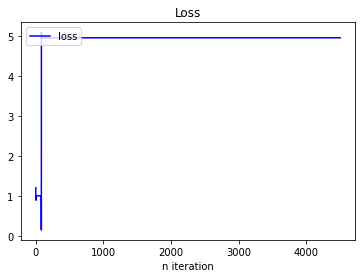

The running loss at 10000 iteration is: 4.960100173950195


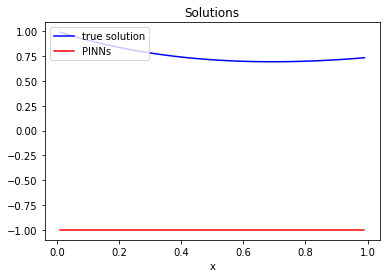

The running loss at 4501 iteration is: 4.960100173950195
The running loss at 4502 iteration is: 4.960100173950195
The running loss at 4503 iteration is: 4.960100173950195
The running loss at 4504 iteration is: 4.960100173950195
The running loss at 4505 iteration is: 4.960100173950195
The running loss at 4506 iteration is: 4.960100173950195
The running loss at 4507 iteration is: 4.960100173950195
The running loss at 4508 iteration is: 4.960100173950195
The running loss at 4509 iteration is: 4.960100173950195
The running loss at 4510 iteration is: 4.960100173950195
The running loss at 4511 iteration is: 4.960100173950195
The running loss at 4512 iteration is: 4.960100173950195
The running loss at 4513 iteration is: 4.960100173950195
The running loss at 4514 iteration is: 4.960100173950195
The running loss at 4515 iteration is: 4.960100173950195
The running loss at 4516 iteration is: 4.960100173950195
The running loss at 4517 iteration is: 4.960100173950195
The running loss at 4518 iterat

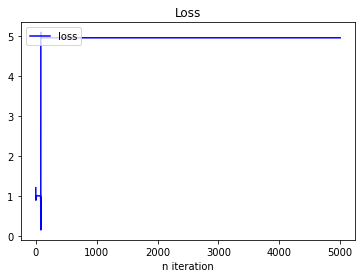

The running loss at 10000 iteration is: 4.960100173950195


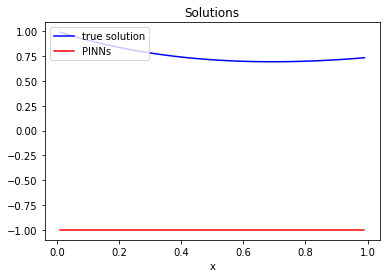

The running loss at 5001 iteration is: 4.960100173950195
The running loss at 5002 iteration is: 4.960100173950195
The running loss at 5003 iteration is: 4.960100173950195
The running loss at 5004 iteration is: 4.960100173950195
The running loss at 5005 iteration is: 4.960100173950195
The running loss at 5006 iteration is: 4.960100173950195
The running loss at 5007 iteration is: 4.960100173950195
The running loss at 5008 iteration is: 4.960100173950195
The running loss at 5009 iteration is: 4.960100173950195
The running loss at 5010 iteration is: 4.960100173950195
The running loss at 5011 iteration is: 4.960100173950195
The running loss at 5012 iteration is: 4.960100173950195
The running loss at 5013 iteration is: 4.960100173950195
The running loss at 5014 iteration is: 4.960100173950195
The running loss at 5015 iteration is: 4.960100173950195
The running loss at 5016 iteration is: 4.960100173950195
The running loss at 5017 iteration is: 4.960100173950195
The running loss at 5018 iterat

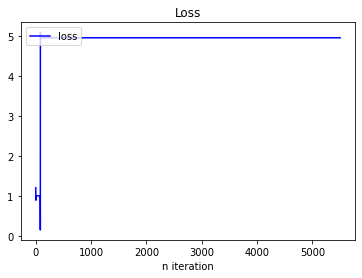

The running loss at 10000 iteration is: 4.960100173950195


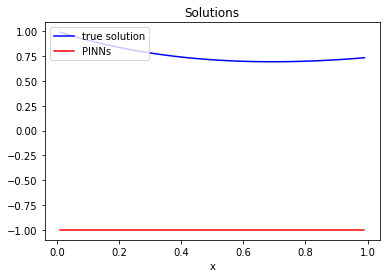

The running loss at 5501 iteration is: 4.960100173950195
The running loss at 5502 iteration is: 4.960100173950195
The running loss at 5503 iteration is: 4.960100173950195
The running loss at 5504 iteration is: 4.960100173950195
The running loss at 5505 iteration is: 4.960100173950195
The running loss at 5506 iteration is: 4.960100173950195
The running loss at 5507 iteration is: 4.960100173950195
The running loss at 5508 iteration is: 4.960100173950195
The running loss at 5509 iteration is: 4.960100173950195
The running loss at 5510 iteration is: 4.960100173950195
The running loss at 5511 iteration is: 4.960100173950195
The running loss at 5512 iteration is: 4.960100173950195
The running loss at 5513 iteration is: 4.960100173950195
The running loss at 5514 iteration is: 4.960100173950195
The running loss at 5515 iteration is: 4.960100173950195
The running loss at 5516 iteration is: 4.960100173950195
The running loss at 5517 iteration is: 4.960100173950195
The running loss at 5518 iterat

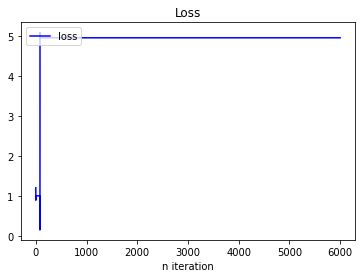

The running loss at 10000 iteration is: 4.960100173950195


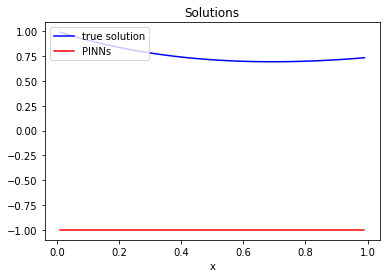

The running loss at 6001 iteration is: 4.960100173950195
The running loss at 6002 iteration is: 4.960100173950195
The running loss at 6003 iteration is: 4.960100173950195
The running loss at 6004 iteration is: 4.960100173950195
The running loss at 6005 iteration is: 4.960100173950195
The running loss at 6006 iteration is: 4.960100173950195
The running loss at 6007 iteration is: 4.960100173950195
The running loss at 6008 iteration is: 4.960100173950195
The running loss at 6009 iteration is: 4.960100173950195
The running loss at 6010 iteration is: 4.960100173950195
The running loss at 6011 iteration is: 4.960100173950195
The running loss at 6012 iteration is: 4.960100173950195
The running loss at 6013 iteration is: 4.960100173950195
The running loss at 6014 iteration is: 4.960100173950195
The running loss at 6015 iteration is: 4.960100173950195
The running loss at 6016 iteration is: 4.960100173950195
The running loss at 6017 iteration is: 4.960100173950195
The running loss at 6018 iterat

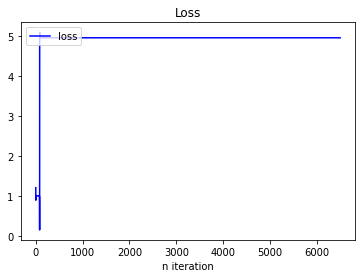

The running loss at 10000 iteration is: 4.960100173950195


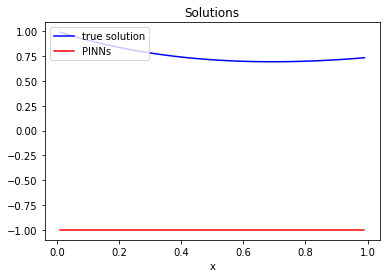

The running loss at 6501 iteration is: 4.960100173950195
The running loss at 6502 iteration is: 4.960100173950195
The running loss at 6503 iteration is: 4.960100173950195
The running loss at 6504 iteration is: 4.960100173950195
The running loss at 6505 iteration is: 4.960100173950195
The running loss at 6506 iteration is: 4.960100173950195
The running loss at 6507 iteration is: 4.960100173950195
The running loss at 6508 iteration is: 4.960100173950195
The running loss at 6509 iteration is: 4.960100173950195
The running loss at 6510 iteration is: 4.960100173950195
The running loss at 6511 iteration is: 4.960100173950195
The running loss at 6512 iteration is: 4.960100173950195
The running loss at 6513 iteration is: 4.960100173950195
The running loss at 6514 iteration is: 4.960100173950195
The running loss at 6515 iteration is: 4.960100173950195
The running loss at 6516 iteration is: 4.960100173950195
The running loss at 6517 iteration is: 4.960100173950195
The running loss at 6518 iterat

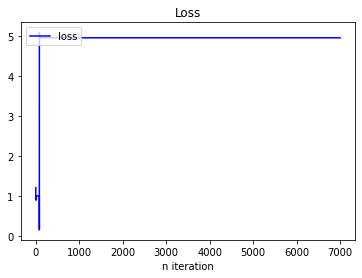

The running loss at 10000 iteration is: 4.960100173950195


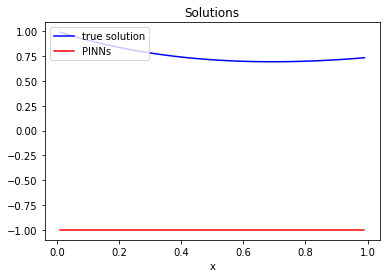

The running loss at 7001 iteration is: 4.960100173950195
The running loss at 7002 iteration is: 4.960100173950195
The running loss at 7003 iteration is: 4.960100173950195
The running loss at 7004 iteration is: 4.960100173950195
The running loss at 7005 iteration is: 4.960100173950195
The running loss at 7006 iteration is: 4.960100173950195
The running loss at 7007 iteration is: 4.960100173950195
The running loss at 7008 iteration is: 4.960100173950195
The running loss at 7009 iteration is: 4.960100173950195
The running loss at 7010 iteration is: 4.960100173950195
The running loss at 7011 iteration is: 4.960100173950195
The running loss at 7012 iteration is: 4.960100173950195
The running loss at 7013 iteration is: 4.960100173950195
The running loss at 7014 iteration is: 4.960100173950195
The running loss at 7015 iteration is: 4.960100173950195
The running loss at 7016 iteration is: 4.960100173950195
The running loss at 7017 iteration is: 4.960100173950195
The running loss at 7018 iterat

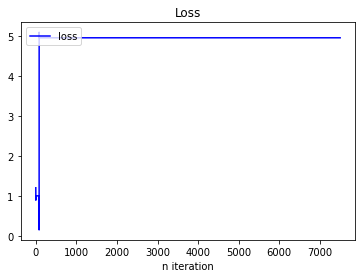

The running loss at 10000 iteration is: 4.960100173950195


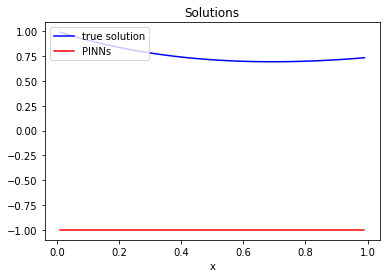

The running loss at 7501 iteration is: 4.960100173950195
The running loss at 7502 iteration is: 4.960100173950195
The running loss at 7503 iteration is: 4.960100173950195
The running loss at 7504 iteration is: 4.960100173950195
The running loss at 7505 iteration is: 4.960100173950195
The running loss at 7506 iteration is: 4.960100173950195
The running loss at 7507 iteration is: 4.960100173950195
The running loss at 7508 iteration is: 4.960100173950195
The running loss at 7509 iteration is: 4.960100173950195
The running loss at 7510 iteration is: 4.960100173950195
The running loss at 7511 iteration is: 4.960100173950195
The running loss at 7512 iteration is: 4.960100173950195
The running loss at 7513 iteration is: 4.960100173950195
The running loss at 7514 iteration is: 4.960100173950195
The running loss at 7515 iteration is: 4.960100173950195
The running loss at 7516 iteration is: 4.960100173950195
The running loss at 7517 iteration is: 4.960100173950195
The running loss at 7518 iterat

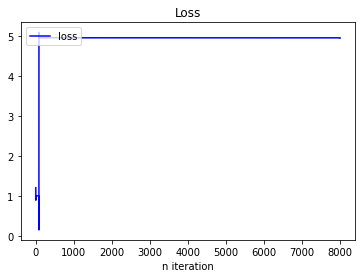

The running loss at 10000 iteration is: 4.955209732055664


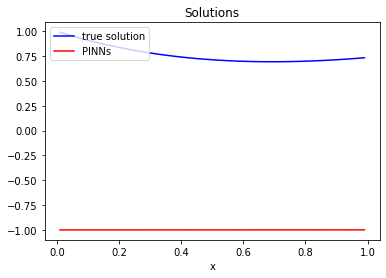

The running loss at 8001 iteration is: 4.935341835021973
The running loss at 8002 iteration is: 4.8102617263793945
The running loss at 8003 iteration is: 4.128935813903809
The running loss at 8004 iteration is: 2.081880807876587
The running loss at 8005 iteration is: 1.3625057935714722
The running loss at 8006 iteration is: 1.712367057800293
The running loss at 8007 iteration is: 1.1774235963821411
The running loss at 8008 iteration is: 0.9935242533683777
The running loss at 8009 iteration is: 0.8857713937759399
The running loss at 8010 iteration is: 0.34744271636009216
The running loss at 8011 iteration is: 0.2678140103816986
The running loss at 8012 iteration is: 0.6201470494270325
The running loss at 8013 iteration is: 0.6668450832366943
The running loss at 8014 iteration is: 0.5413037538528442
The running loss at 8015 iteration is: 0.18659047782421112
The running loss at 8016 iteration is: 0.05105531960725784
The running loss at 8017 iteration is: 0.3270992040634155
The running los

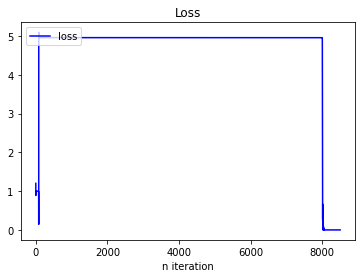

The running loss at 10000 iteration is: 0.00010077105980599299


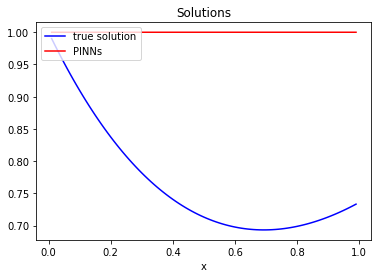

The running loss at 8501 iteration is: 0.00010077108163386583
The running loss at 8502 iteration is: 0.00010077108890982345
The running loss at 8503 iteration is: 0.00010077113256556913
The running loss at 8504 iteration is: 0.0001007711689453572
The running loss at 8505 iteration is: 0.0001007711689453572
The running loss at 8506 iteration is: 0.00010077119077323005
The running loss at 8507 iteration is: 0.00010077126353280619
The running loss at 8508 iteration is: 0.0001007712708087638
The running loss at 8509 iteration is: 0.00010077129263663664
The running loss at 8510 iteration is: 0.0001007713217404671
The running loss at 8511 iteration is: 0.00010077132901642472
The running loss at 8512 iteration is: 0.00010077133629238233
The running loss at 8513 iteration is: 0.00010077138722408563
The running loss at 8514 iteration is: 0.00010077148908749223
The running loss at 8515 iteration is: 0.0001007715254672803
The running loss at 8516 iteration is: 0.00010077156184706837
The running l

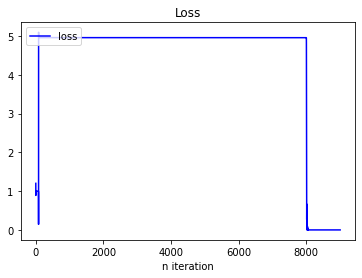

The running loss at 10000 iteration is: 0.00010078879859065637


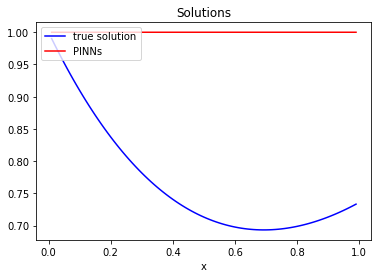

The running loss at 9001 iteration is: 0.00010078883497044444
The running loss at 9002 iteration is: 0.00010078887862619013
The running loss at 9003 iteration is: 0.00010078888590214774
The running loss at 9004 iteration is: 0.00010078894410980865
The running loss at 9005 iteration is: 0.00010078895866172388
The running loss at 9006 iteration is: 0.00010078900959342718
The running loss at 9007 iteration is: 0.00010078906052513048
The running loss at 9008 iteration is: 0.00010078908962896094
The running loss at 9009 iteration is: 0.00010078914056066424
The running loss at 9010 iteration is: 0.00010078915511257946
The running loss at 9011 iteration is: 0.00010078916238853708
The running loss at 9012 iteration is: 0.0001007891696644947
The running loss at 9013 iteration is: 0.0001007891696644947
The running loss at 9014 iteration is: 0.00010078927152790129
The running loss at 9015 iteration is: 0.0001007892788038589
The running loss at 9016 iteration is: 0.00010078934428747743
The running

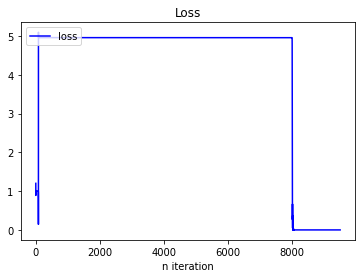

The running loss at 10000 iteration is: 0.00010081301297759637


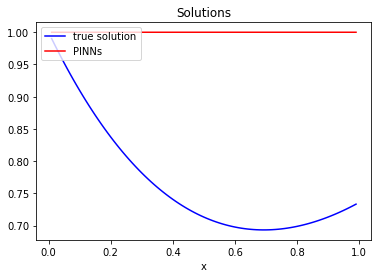

The running loss at 9501 iteration is: 0.00010081307118525729
The running loss at 9502 iteration is: 0.00010081314394483343
The running loss at 9503 iteration is: 0.00010081318760057911
The running loss at 9504 iteration is: 0.00010081326763611287
The running loss at 9505 iteration is: 0.0001008133331197314
The running loss at 9506 iteration is: 0.00010081337677547708
The running loss at 9507 iteration is: 0.00010081342043122277
The running loss at 9508 iteration is: 0.00010081342043122277
The running loss at 9509 iteration is: 0.00010081349319079891
The running loss at 9510 iteration is: 0.00010081352229462937
The running loss at 9511 iteration is: 0.00010081355139845982
The running loss at 9512 iteration is: 0.00010081356595037505
The running loss at 9513 iteration is: 0.00010081360960612074
The running loss at 9514 iteration is: 0.00010081372602144256
The running loss at 9515 iteration is: 0.0001008137478493154
The running loss at 9516 iteration is: 0.0001008137987810187
The running

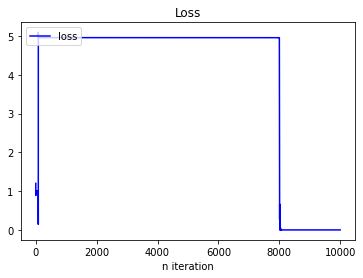

The running loss at 10000 iteration is: 0.0001008466279017739


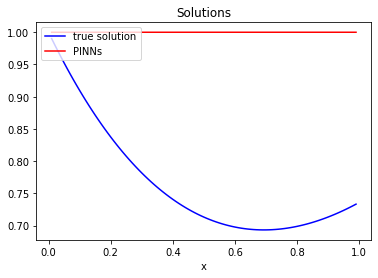

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
time0 = time()
num_e = 10000
iter = []
test_error_vec = []
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1)
for e in range(num_e):
    running_loss = 0
    # call zero_Grad
    optimizer.zero_grad() 
    # Compute u_hat, d2u_hat
    u_hat = torch.tensor(np.array([]))
    du_dx = torch.tensor(np.array([]))
    for xi in x_init_np:
        x_tensor = torch.tensor([xi], requires_grad=True)
        temp = model(x_tensor.float())
        u_hat = torch.hstack([u_hat, temp])
        deri = autograd.grad(model(x_tensor.float()), x_tensor, create_graph=True)[0]
        du_dx = torch.hstack([du_dx, deri])
    loss = torch.mean((du_dx + u_hat - x_tensor)**2) + (model(torch.tensor([0.])-1))**2
    loss.backward()
    optimizer.step() 
    scheduler2.step()

    running_loss += loss.clone().item()    
    
    print(f"The running loss at {e} iteration is: {running_loss}")
    test_error_vec.append(running_loss)
    iter.append(e)
    if (e%500 ==0):
      draw_result(iter, test_error_vec)
      print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
      y_true = u_star_func(x_init_np)
      draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')      
draw_result(iter, test_error_vec)
print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
y_true = u_star_func(x_init_np)
draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')

# Finite difference

In [ ]:
input_size = 1
output_size = 1
k = 16
model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Tanh()
)


In [ ]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init = torch.tensor(x_init_np, requires_grad= True)
print(x_init.shape)

torch.Size([101])


In [ ]:
loss_mse = nn.MSELoss()

def run_train(lr = 0.001, num_e = 1000):
    # optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=3.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    
    for e in range(num_e):
        running_loss = 0
        
        optimizer.zero_grad()  # call zero_Grad
        
        u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            u_hat = torch.hstack([u_hat, temp])
        d1u_hat = u_hat.clone()  
        loss = (u_hat[0]-1)**2
        u_hat[0] = 1  
        d1u_hat[1:-1] = (-u_hat[0:-2] + u_hat[2:])/(2*step)
        loss = loss + loss_mse(d1u_hat[1:-1] + u_hat[1:-1] , x_init[1:-1]) 
        loss.backward()
        optimizer.step() 

        running_loss += loss.clone().item()    
        if (e % 10 == 0):
            print(f"The running loss at {e+1} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)

    draw_result(iter, test_error_vec)

    y_true = u_star_func(x_init_np)
    draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')
    print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))

The running loss at 1 iteration is: 23.879696083175727
The running loss at 11 iteration is: 0.3284544075015208
The running loss at 21 iteration is: 0.3092261481160041
The running loss at 31 iteration is: 0.31657755818232286
The running loss at 41 iteration is: 0.31842314642704783
The running loss at 51 iteration is: 0.3187256217798627
The running loss at 61 iteration is: 0.3184578374358855
The running loss at 71 iteration is: 0.31792036073321933
The running loss at 81 iteration is: 0.3172106861245335
The running loss at 91 iteration is: 0.3163528781701802
The running loss at 101 iteration is: 0.3153410183964993
The running loss at 111 iteration is: 0.3141543586767262
The running loss at 121 iteration is: 0.3127624269146944
The running loss at 131 iteration is: 0.31112643150989905
The running loss at 141 iteration is: 0.3091990727582452
The running loss at 151 iteration is: 0.3069239645951152
The running loss at 161 iteration is: 0.3042343815486559
The running loss at 171 iteration is: 

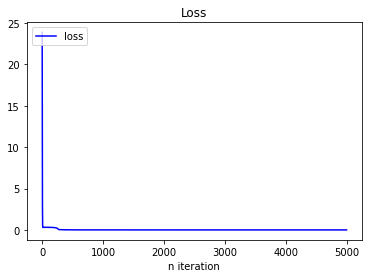

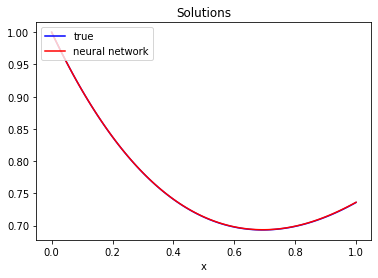

7.36240730837828e-08
Time = 191.11639213562012


In [ ]:
time0 = time()
run_train(lr=0.01, num_e= 5000)
print(f"Time = {time() - time0}")

In [ ]:
def evaluate_np(x_data_np):
    u_hat = []
    for x in x_data_np:
        x_tensor = torch.tensor(np.array([x]), requires_grad= True)
        temp = model(x_tensor.float())
        u_hat.append(temp.clone().item())
    return u_hat

In [ ]:
def evaluate_error_np(x_data_np):
    y_pred = evaluate_np(x_data_np)
    y_true = u_star_func(x_data_np)
    return np.mean(np.square(y_true -  y_pred))

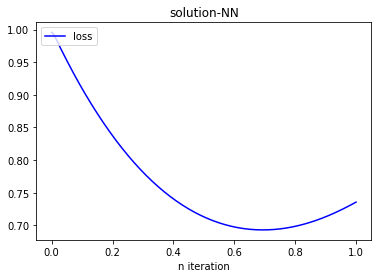

1.1533252484662064e-07

In [ ]:
x_init_np2 = np.arange(start=a, stop=b+step/2, step=step/2)
x_init2 = torch.tensor(x_init_np2, requires_grad= True)
y_pred2 = evaluate_np(x_init_np2)
draw_result(x_init_np2, y_pred2, 'solution-NN')
evaluate_error_np(x_init_np2)

In [ ]:
step_size = []
error = []
for k in [4,6,8,10,12, 14, 26]:
    x_vec = np.arange(start=a, stop=b+step/k, step=step/k)
    y_pred = evaluate_np(x_vec)
    error.append(evaluate_error_np(x_vec))
    step_size.append(step/k)

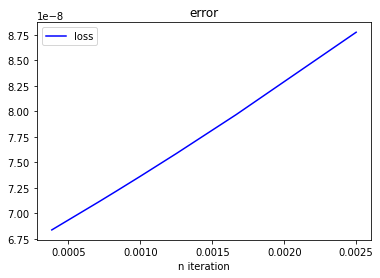

[0.0025, 0.0016666666666666668, 0.00125, 0.001, 0.0008333333333333334, 0.0007142857142857143, 0.0003846153846153846]


In [ ]:
draw_result(step_size[::-1], error[::-1], 'error')
print(step_size)